In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch 
import os
import torch
from torch.utils.data import DataLoader
import hashlib
import json
import shutil
import sys

sys.path.append("src")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_torch_model


# programatically load last saved weight
weights_gpt_2_style = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-Cluster-20k-Tau-1-WeightDecay0-wsilence-2000-context/saved_weights/model_step_49995.pth"
config_gpt_2_style = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-Cluster-20k-Tau-1-WeightDecay0-wsilence-2000-context/config.json"

## new model ###
with open(config_gpt_2_style, 'r') as f:
    config = json.load(f)  # Load and parse the JSON file

 # Data Loading
collate_fn = CollateFunction(segment_length=config['context'])
train_dataset = SongDataSet_Image("/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/umap_eval_dataset_llb16", num_classes=config['num_clusters'], subsampling=True, subsample_factor=config['subsample'], remove_silences=config['remove_silences'])
test_dataset = SongDataSet_Image("/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/umap_eval_dataset_llb16", num_classes=config['num_clusters'], subsampling=True, subsample_factor=config['subsample'], remove_silences=config['remove_silences'])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers=16)

# Initialize model
model = TweetyBERT(
    d_transformer=config['d_transformer'], 
    nhead_transformer=config['nhead_transformer'],
    embedding_dim=config['embedding_dim'],
    num_labels=config['num_clusters'],
    tau=None,
    dropout=config['dropout'],
    dim_feedforward=config['dim_feedforward'],
    transformer_layers=config['transformer_layers'],
    m=config['m'],
    p=config['p'],
    alpha=config['alpha'],
    sigma=config['sigma'],
    length = config['context']
).to(device)

detailed_count_parameters(model)
load_torch_model(dir=weights_gpt_2_style, model=model)

Total Trainable Parameters: 7,967,162


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class SongDataSet_Image(Dataset):
    def __init__(self, file_dir, num_classes=21, segment_length=370):
        self.file_path = []
        self.num_classes = num_classes
        self.segment_length = segment_length

        for file in os.listdir(file_dir):
            self.file_path.append(os.path.join(file_dir, file))

    def __getitem__(self, index):
        file_path = self.file_path[index]
        data = np.load(file_path, allow_pickle=True)
        spectogram = data['s']

        spectogram = spectogram[20:216,:]

        ground_truth_labels = data['labels']

        # Z-score normalization
        mean_val = spectogram.mean()
        std_val = spectogram.std()
        spectogram = (spectogram - mean_val) / (std_val + 1e-7)  # Adding a small constant to prevent division by zero
        
        # Replace NaN values with zeros
        spectogram[np.isnan(spectogram)] = 0

        # Convert to tensor
        spectogram = torch.from_numpy(spectogram).float().permute(1, 0)  # Bringing spectrogram to length x height


        ground_truth_labels = torch.tensor(ground_truth_labels, dtype=torch.int64).squeeze(0)

        # Convert label to one-hot encoding
        ground_truth_labels = F.one_hot(ground_truth_labels, num_classes=self.num_classes).float()

        return spectogram, ground_truth_labels 

    def __len__(self):
        return len(self.file_path)

class CollateFunction:
    def __init__(self, segment_length=370):
        self.segment_length = segment_length

    def __call__(self, batch):
        # Unzip the batch (a list of (spectrogram, ground_truth_labels) tuples)
        spectrograms, ground_truth_labels = zip(*batch)

        # Create lists to hold the processed tensors
        spectrograms_processed = []
        ground_truth_labels_processed = []

        # Each sample in batch
        for spectrogram, ground_truth_label in zip(spectrograms, ground_truth_labels):
            # Truncate if larger than context window or take random window
            if spectrogram.shape[0] > self.segment_length:
                start = torch.randint(0, spectrogram.shape[0] - self.segment_length, (1,)).item()
                end = start + self.segment_length
                spectrogram = spectrogram[start:end]
                ground_truth_label = ground_truth_label[start:end]
            elif spectrogram.shape[0] < self.segment_length:
                # Pad with 0s if shorter
                pad_amount = self.segment_length - spectrogram.shape[0]
                spectrogram = F.pad(spectrogram, (0, 0, 0, pad_amount), 'constant', 0)
                ground_truth_label = F.pad(ground_truth_label, (0, 0, 0, pad_amount), 'constant', 0)

            # Append the processed tensors to the lists
            spectrograms_processed.append(spectrogram)
            ground_truth_labels_processed.append(ground_truth_label)

        # Stack tensors along a new dimension
        spectrograms = torch.stack(spectrograms_processed, dim=0)
        ground_truth_labels = torch.stack(ground_truth_labels_processed, dim=0)

        # Final reshape for model
        spectrograms = spectrograms.unsqueeze(1).permute(0, 1, 3, 2)

        return spectrograms, ground_truth_labels

In [4]:
from torch.utils.data import DataLoader

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/test"

train_dataset = SongDataSet_Image(train_dir)
test_dataset = SongDataSet_Image(test_dir)

collate_fn = CollateFunction(segment_length=2000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [5]:
import torch
import torch.nn as nn
import math
import numpy as np 
import torch.nn.functional as F

num_classes = 21 

class TweetyBERTClassifier(nn.Module):
    def __init__(self, tweetybert_model, num_classes):
        super(TweetyBERTClassifier, self).__init__()
        self.tweetybert_model = tweetybert_model
        # Assuming the output dimension of TweetyBERT is `embedding_dim`
        self.classifier = nn.Linear(384, num_classes)

    def forward(self, input):
        # Use the existing TweetyBERT model to get the features
        features, layers = self.tweetybert_model.inference_forward(input)
        features = layers[-1]['V']
        logits = self.classifier(features)
        return logits
    
    def cross_entropy_loss(self, predictions, targets):
        """loss function for TweetyNet
        Parameters
        ----------
        y_pred : torch.Tensor
            output of TweetyNet model, shape (batch, classes, timebins)
        y_true : torch.Tensor
            one-hot encoded labels, shape (batch, classes, timebins)
        Returns
        -------
        loss : torch.Tensor
            mean cross entropy loss
        """
        loss = nn.CrossEntropyLoss()
        return loss(predictions, targets)

classifier_model = TweetyBERTClassifier(model, num_classes)

def freeze_all_but_classifier(model):
    # Loop through all submodules of the model except the classifier
    for name, module in model.named_modules():
        if name != "classifier":
            # Freeze all parameters inside the current module
            for param in module.parameters():
                param.requires_grad = False

    # Unfreeze the parameters of the classifier
    for param in model.classifier.parameters():
        param.requires_grad = True

#Freeze the weights of the model
freeze_all_but_classifier(classifier_model)


## Training Loop

In [6]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)

model = classifier_model
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=0.0)

# Training setup
batches_per_eval = 25  # Evaluate after every 100 baThis function should take two data points as input and return a distance value. Ensure that it adheres to the properties of a distance metric, such as non-negativity, symmetry, and the triangle inequality.tches
total_batches = 0  # Total number of batches processed
desired_total_batches = 2500  # Set your desired total number of batches
total_loss = 0  # Initialize total loss

cuda:0
Number of parameters: 8085


In [7]:
# Early stopping parameters
patience = 4  # Number of validations to wait for improvement
num_val_no_improve = 0  # Counter for validations since last improvement
best_val_loss = float('inf')  # Best observed validation loss
stop_training = False  # Flag to stop training

In [8]:
import torch
import matplotlib.pyplot as plt

# Assuming other necessary imports and model setup are done above this

def frame_error_rate(y_pred, y_true):
    """
    Compute the frame error rate.
    y_pred: Tensor of shape (batch_size, num_classes, time_steps) - typically the output of a softmax
    y_true: Tensor of shape (batch_size, time_steps) - ground truth labels
    Returns the frame error rate.
    """
    y_pred = y_pred.permute(0,2,1).argmax(-1)

    mismatches = (y_pred != y_true).float()  # y_true is already in the correct format
    error = mismatches.sum() / y_true.size(0) / y_true.size(1)
    return error * 100

def validate_model(model, test_loader):
    model.eval()
    total_val_loss = 0
    total_frame_error = 0
    num_val_batches = 0
    with torch.no_grad():
        for i, (spectrogram, label) in enumerate(test_loader):
            if i > batches_per_eval:
                break
            spectrogram = spectrogram.to(device)
            label = label.to(device)

            output = model.forward(spectrogram)

            label = label.squeeze(1)
            # Argmax bc CE does not take one hot
            label_indices = label.argmax(dim=-1)

            output = output.permute(0,2,1)

            loss = model.cross_entropy_loss(predictions=output, targets=label_indices)

            total_val_loss += loss.item()
            total_frame_error += frame_error_rate(output, label_indices).item()
            num_val_batches += 1

    return total_val_loss / num_val_batches, total_frame_error / num_val_batches

initial_val_loss, initial_frame_error = validate_model(model, test_loader)

# Initialize lists for storing raw and moving average data
loss_list, val_loss_list, frame_error_rate_list = [initial_val_loss], [initial_val_loss], [initial_frame_error]
loss_buffer, val_loss_buffer, frame_error_buffer = [], [], []


while total_batches < desired_total_batches:
    for i, (spectrogram, label) in enumerate(train_loader):
        if total_batches >= desired_total_batches:
            break

        spectrogram = spectrogram.to(device)

        label = label.to(device)

        output = model.forward(spectrogram)
        label = label.squeeze(1)
        label = label.permute(0,2,1)

        # Argmax bc CE does not take one hot
        label_indices = label.argmax(dim=-2)

        output = output.permute(0,2,1)

        loss = model.cross_entropy_loss(predictions=output, targets=label_indices)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_batches += 1
        loss_buffer.append(loss.item())

        if total_batches % batches_per_eval == 0:
            avg_val_loss, avg_frame_error = validate_model(model, test_loader)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                num_val_no_improve = 0
            else:
                num_val_no_improve += 1
                if num_val_no_improve >= patience:
                    print("Early stopping triggered")
                    stop_training = True
                    break

            for times in range(batches_per_eval):
                val_loss_buffer.append(avg_val_loss)
                frame_error_buffer.append(avg_frame_error)

                # Calculate dynamic moving averages
                window_size = min(total_batches, 10)  # Use the smaller of total_batches or 10
                loss_list.append(np.mean(loss_buffer[-window_size:]))
                val_loss_list.append(np.mean(val_loss_buffer[-window_size:]))
                frame_error_rate_list.append(np.mean(frame_error_buffer[-window_size:]))

            if loss_list and val_loss_list and frame_error_rate_list:
                print(f'After {total_batches} batches, Training Loss: {loss_list[-1]:.2e}, Validation Loss: {val_loss_list[-1]:.2e}, Frame Error Rate: {frame_error_rate_list[-1]:.2f}%')
        
    if stop_training == True:
        break 

# Plotting the results with moving averages
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Smoothed Training Loss')
plt.plot(val_loss_list, label='Smoothed Validation Loss')
plt.title('Smoothed Loss over Batches')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()

# Frame error rate plot
plt.subplot(1, 2, 2)
plt.plot(frame_error_rate_list, label='Smoothed Frame Error Rate', color='red')
plt.title('Smoothed Frame Error Rate over Batches')
plt.xlabel('Batches')
plt.ylabel('Error Rate (%)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final smoothed loss after {total_batches} batches: {loss_list[-1]}")

After 25 batches, Training Loss: 5.36e-01, Validation Loss: 4.19e-01, Frame Error Rate: 12.29%
After 50 batches, Training Loss: 3.51e-01, Validation Loss: 3.03e-01, Frame Error Rate: 9.60%
After 75 batches, Training Loss: 2.95e-01, Validation Loss: 2.50e-01, Frame Error Rate: 7.77%
After 100 batches, Training Loss: 2.90e-01, Validation Loss: 2.56e-01, Frame Error Rate: 7.86%
After 125 batches, Training Loss: 2.73e-01, Validation Loss: 2.35e-01, Frame Error Rate: 7.17%
After 150 batches, Training Loss: 2.45e-01, Validation Loss: 2.23e-01, Frame Error Rate: 7.13%
After 175 batches, Training Loss: 2.37e-01, Validation Loss: 2.56e-01, Frame Error Rate: 7.62%
After 200 batches, Training Loss: 2.65e-01, Validation Loss: 2.19e-01, Frame Error Rate: 7.17%
After 225 batches, Training Loss: 2.46e-01, Validation Loss: 2.26e-01, Frame Error Rate: 7.17%
After 250 batches, Training Loss: 2.35e-01, Validation Loss: 1.97e-01, Frame Error Rate: 6.54%
After 275 batches, Training Loss: 2.45e-01, Validati

KeyboardInterrupt: 

Evaluating:   0%|          | 0/133 [00:00<?, ?batch/s]

Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.56batch/s]


Total Frame Error Rate: 5.25%


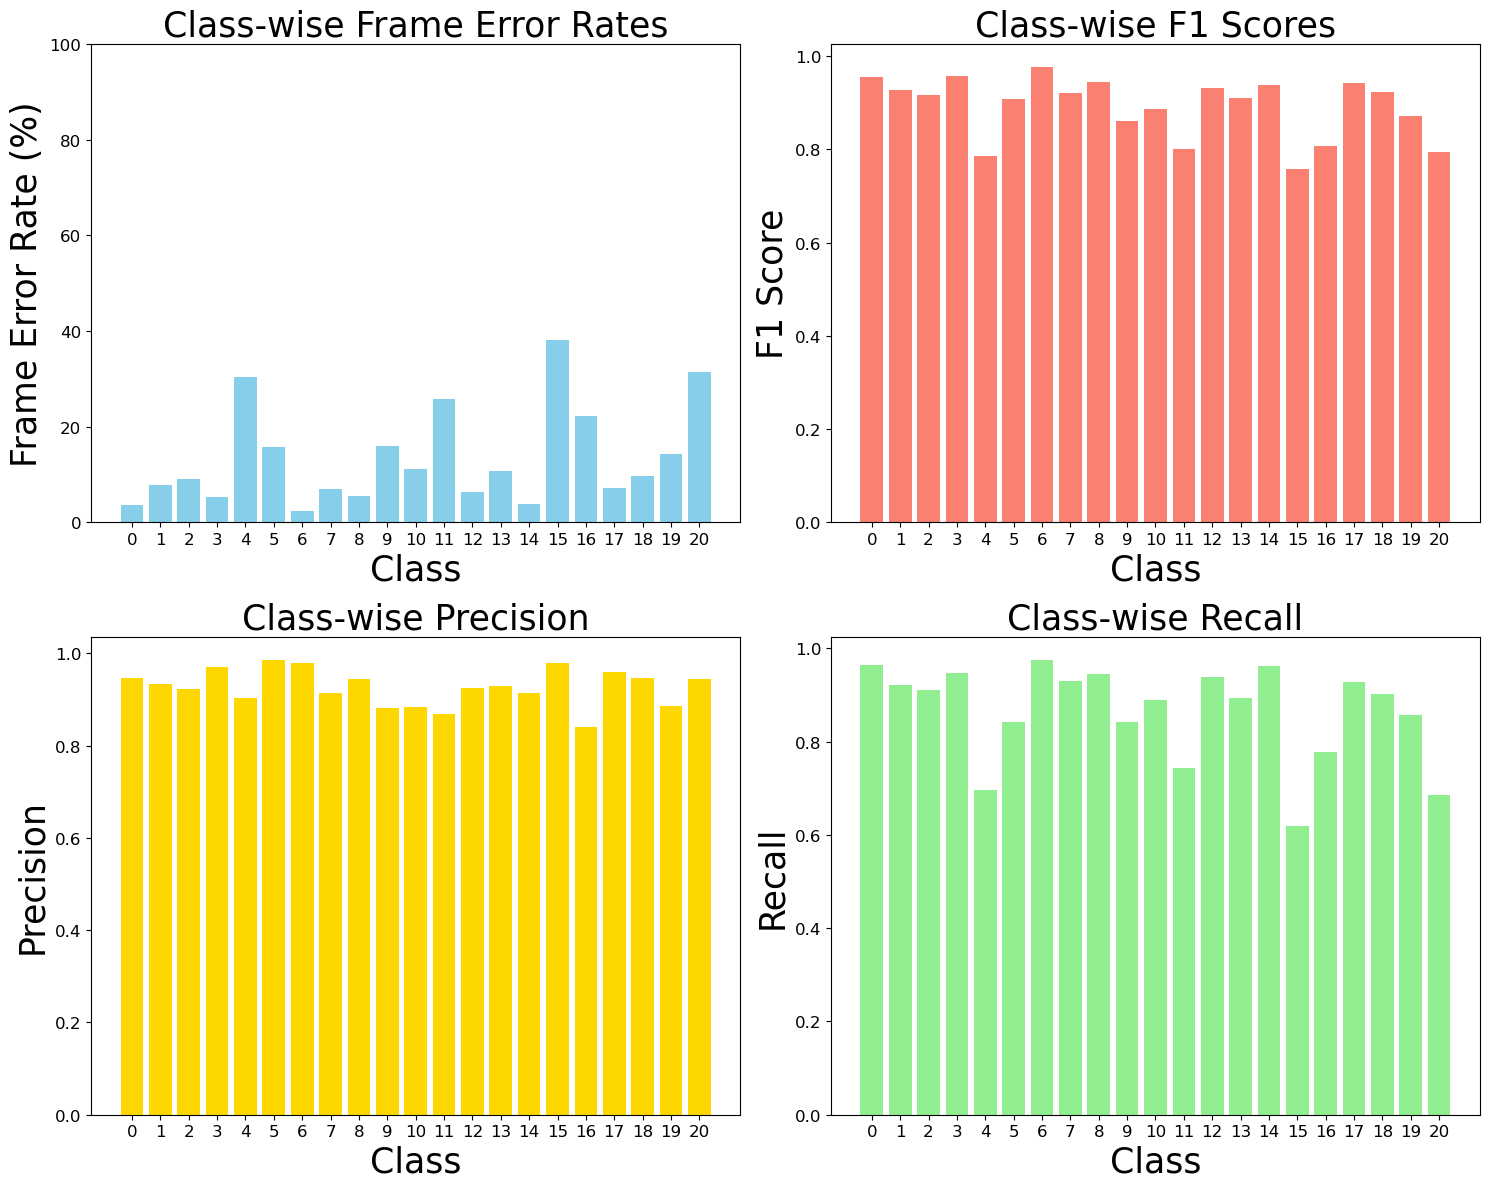

In [ ]:
import torch
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

num_classes = 21  # Update this if the number of classes changes

def validate_model_multiple_passes(model, test_loader, num_passes=1, max_batches=100):
    model.eval()
    # Initialize metrics
    errors_per_class = [0] * num_classes
    correct_per_class = [0] * num_classes
    tp_per_class = [0] * num_classes
    fp_per_class = [0] * num_classes
    fn_per_class = [0] * num_classes
    total_frames = 0
    total_errors = 0

    total_iterations = num_passes * min(max_batches, len(test_loader))
    progress_bar = tqdm(total=total_iterations, desc="Evaluating", unit="batch")

    for _ in range(num_passes):  # Outer loop for multiple passes
        with torch.no_grad():
            for i, (waveform, label) in enumerate(test_loader):
                if i >= max_batches:  # Early stopping condition for each pass
                    break

                waveform = waveform.to(device)
                label = label.to(device)

                output = model.forward(waveform)
                label = label.squeeze(1).permute(0, 2, 1)
                output = output.permute(0,2,1)

                predicted_labels = output.argmax(dim=-2)
                true_labels = label.argmax(dim=-2)

                correct = (predicted_labels == true_labels)
                incorrect = ~correct

                for cls in range(num_classes):  # Iterate over the number of classes
                    class_mask = (true_labels == cls)
                    predicted_class_mask = (predicted_labels == cls)

                    correct_class = correct & class_mask
                    incorrect_class = incorrect & class_mask

                    tp = correct_class.sum().item()
                    fp = (predicted_class_mask & ~class_mask).sum().item()
                    fn = (class_mask & ~predicted_class_mask).sum().item()

                    tp_per_class[cls] += tp
                    fp_per_class[cls] += fp
                    fn_per_class[cls] += fn

                    correct_per_class[cls] += tp
                    errors_per_class[cls] += incorrect_class.sum().item()

                    total_frames += tp + incorrect_class.sum().item()
                    total_errors += incorrect_class.sum().item()

                progress_bar.update(1)  # Update progress bar after each batch

    progress_bar.close()  # Close the progress bar
    # Calculate Precision, Recall, and F1 score per class
    precision_per_class = {}
    recall_per_class = {}
    f1_scores_per_class = {}
    for cls in range(num_classes):
        precision = tp_per_class[cls] / (tp_per_class[cls] + fp_per_class[cls]) if tp_per_class[cls] + fp_per_class[cls] > 0 else 0
        recall = tp_per_class[cls] / (tp_per_class[cls] + fn_per_class[cls]) if tp_per_class[cls] + fn_per_class[cls] > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        precision_per_class[cls] = precision
        recall_per_class[cls] = recall
        f1_scores_per_class[cls] = f1_score

    # Calculate frame error rates, handling division by zero
    class_frame_error_rates = {
        cls: (errors / (errors + correct) * 100 if errors + correct > 0 else float('nan'))
        for cls, (errors, correct) in enumerate(zip(errors_per_class, correct_per_class))
    }

    total_frame_error_rate = (total_errors / total_frames * 100 if total_frames > 0 else float('nan'))
    print(f'Total Frame Error Rate: {total_frame_error_rate:.2f}%')

    class_occurrences = [(correct + errors) / total_frames * 100 for correct, errors in zip(correct_per_class, errors_per_class)]

    return class_frame_error_rates, class_occurrences, f1_scores_per_class, precision_per_class, recall_per_class

# Assuming model and test_loader have been defined and initialized correctly
class_frame_error_rates, class_occurrences, f1_scores_per_class, precision_per_class, recall_per_class = validate_model_multiple_passes(model, test_loader, num_passes=1, max_batches=1250)

# Plotting the class-wise frame error rates, F1 scores, Precision and Recall
classes = list(range(num_classes))
error_rates = [class_frame_error_rates.get(cls, float('nan')) for cls in classes]
f1_scores = [f1_scores_per_class.get(cls, float('nan')) for cls in classes]
precisions = [precision_per_class.get(cls, float('nan')) for cls in classes]
recalls = [recall_per_class.get(cls, float('nan')) for cls in classes]

plt.figure(figsize=(15, 12))

# Subplot 1: Error Rates
plt.subplot(2, 2, 1)
plt.bar(classes, error_rates, color='skyblue')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Frame Error Rate (%)', fontsize=25)
plt.title('Class-wise Frame Error Rates', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)

# Subplot 2: F1 Scores
plt.subplot(2, 2, 2)
plt.bar(classes, f1_scores, color='salmon')
plt.xlabel('Class', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.title('Class-wise F1 Scores', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

# Subplot 3: Precision
plt.subplot(2, 2, 3)
plt.bar(classes, precisions, color='gold')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Precision', fontsize=25)
plt.title('Class-wise Precision', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

# Subplot 4: Recall
plt.subplot(2, 2, 4)
plt.bar(classes, recalls, color='lightgreen')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Recall', fontsize=25)
plt.title('Class-wise Recall', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()
